In [6]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torch

import neuralnet

## Training the model
The neuralnet folder creates a pytorch neural network. The values for the network can be modified there. The training and testing functions are also defined there. Running the model should be as easy as open the data file and running it through the model

In [2]:
data = pd.read_csv("train.csv")
data = data.sample(frac=1)

Isolate the features and labels

In [3]:
Ytrain = data.filter(items=["Status"])
Xtrain = data.drop("Status", axis=1)

In [4]:
print(Xtrain.dtypes)

Unnamed: 0               int64
AgatstonScore2D        float64
MassScore              float64
VolumeScore            float64
Area2D                 float64
                        ...   
ICskewnesstMomentH3    float64
ICkurtosisMomentH1     float64
ICkurtosisMomentH2     float64
ICkurtosisMomentH3     float64
Time                     int64
Length: 80, dtype: object


In [5]:
obj_df = Xtrain.select_dtypes(include=['object', 'string', 'bool']).copy()
obj_df.head()

,isAgZero,isLesion3DBelow5,isAgeBelow60,AgGroupX1,AgGroupX2,AgGroupX3,isArt2plus,isArt3plus
1590,False,False,True,False,False,True,True,True
2648,False,True,False,True,False,False,True,False
1307,True,True,True,False,False,False,False,False
1742,True,True,False,False,False,False,False,False
3312,False,False,False,False,False,True,True,True


We have some boolean values that need to be encoded; let's set the false values to 0 and the true values to 1s

In [6]:
Xtrain.replace({False: 0, True: 1}, inplace=True)

The `train` method in neuralnet.py automatically initializes a the model that is specified in the file, so we don't need to worry about doing this manually. We can just call the train method and it will train the network

In [7]:
# convert to numpy arrays
Xtrain = Xtrain.to_numpy()
Ytrain = Ytrain.to_numpy()

In [8]:
Xtrain.shape

(3366, 80)

Final Loss: 0.41220539808273315


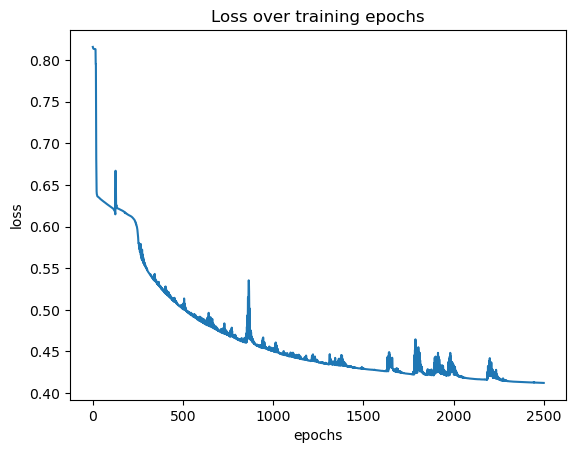

In [9]:
model, epochs, loss = neuralnet.train(Xtrain, Ytrain, num_epochs=2500)

# plot the training
plt.plot(epochs, loss)
plt.title("Loss over training epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Let's quickly test the model

In [32]:
test_data = pd.read_csv("train.csv")

# isolate X,Y
Xtest = test_data.drop("Status", axis=1)
Ytest = test_data.filter(items=["Status"])

# encode the booleans
Xtest.replace({False: 0, True: 1}, inplace=True)

# convert to numpy
Xtest = Xtest.to_numpy()
Ytest = Ytest.to_numpy()

In [33]:
# test
acc, preds = neuralnet.test(model, Xtest, Ytest)
print(f"Model Accuracy: {acc}")

Model Accuracy: 0.9111705422401428


In [ ]:
# save the preds
preds = pd.DataFrame(preds)
preds["labels"] = Ytest
preds.to_csv("preds.csv")
preds.head()

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import torch

In [35]:
preds = torch.Tensor(torch.from_numpy(preds)).float()
probs = F.softmax(preds, dim=1)[:,1]
y_score = probs.detach().numpy()
#print(y_score)
nn_fpr, nn_tpr, nn_thresholds = roc_curve(Ytest, y_score)

0.9073931090288436


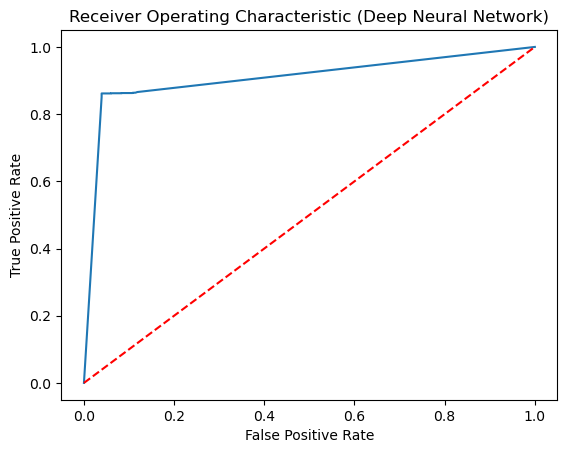

In [38]:
print(auc(nn_fpr, nn_tpr))

plt.plot(nn_fpr, nn_tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (Deep Neural Network)")
plt.show()

We know that our training set is 50/50 for each label. To make sure that we aren't just outputting one number, we can test against the training set. If we get an accuracy of .5, we know that there is just a specific value being outputted without the model learning any of the features.

In [19]:
acc, train_preds = neuralnet.test(model, Xtrain, Ytrain)
train_preds = pd.DataFrame(train_preds)
train_preds["labels"] = Ytrain
print(f"Model Accuracy: {acc}")

Model Accuracy: 0.9099822044372559


Let's save the parameters so that we can load them in easily

In [20]:
torch.save(model.state_dict(), "parameters_long.pt")

## Kaplan-Meier Plot

In [4]:
test_data = pd.read_csv("test.csv")

# isolate X,Y
Xtest = test_data.drop("Status", axis=1)
Ytest = test_data.filter(items=["Status"])

# encode the booleans
Xtest.replace({False: 0, True: 1}, inplace=True)

# convert to numpy
Xtest = Xtest.to_numpy()
Ytest = Ytest.to_numpy()

In [7]:
model = neuralnet.TorchModel(Xtest.shape[1])
model.load_state_dict(torch.load("parameters_long.pt"))

<All keys matched successfully>

In [10]:
# test
acc, preds = neuralnet.test(model, Xtest, Ytest)
print(f"Model Accuracy: {acc}")

# save the preds
Ypred = preds
preds = pd.DataFrame(preds)
preds["labels"] = Ytest
preds.to_csv("preds.csv")
preds.head()

Model Accuracy: 0.8821138143539429


,0,1,labels
0,1.0,4.622921e-34,0
1,1.0,0.000000e+00,0
2,1.0,0.000000e+00,0
3,1.0,1.348687e-34,0
4,1.0,2.690777e-30,0


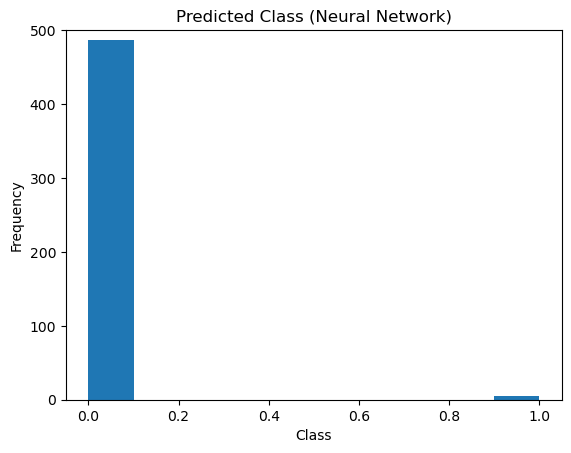

In [13]:
plt.hist(preds[1], bins=10)
plt.title('Predicted Class (Neural Network)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.ylim(0, 500)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(Ytest, y_pred)
print(confusion_matrix)

Kaplan meier plots allow clinicians and individuals to understand risk of an event occuring over time. We can do a similar analysis using the testing set here. <br><br>

The basic premise is this:
- We have a set of data which is labeled by the model, we can associate the time values with the model output
- then we can create a ratio of event occurred:total population at a specific time point and plot that as the "risk" for that time

In [14]:
preds["prediction"] = [0 if pred_0 >= 0.5 else 1 for pred_0 in preds[0]]
print(f"{preds['labels'].sum()} vs {preds['prediction'].sum()}")

57 vs 11


In [15]:
preds["time"] = test_data["Time"]
preds.head()

,0,1,labels,prediction,time
0,1.0,1.049379e-08,0,0,313
1,1.0,8.896423e-31,0,0,551
2,1.0,2.259896e-38,0,0,211
3,1.0,1.955808e-22,0,0,1520
4,1.0,1.923173e-07,0,0,285


In [16]:
preds["time"] = (preds["time"] / 30).astype(int)
preds.head()

,0,1,labels,prediction,time
0,1.0,1.049379e-08,0,0,10
1,1.0,8.896423e-31,0,0,18
2,1.0,2.259896e-38,0,0,7
3,1.0,1.955808e-22,0,0,50
4,1.0,1.923173e-07,0,0,9


Now that the predictions and time are in a consolidated place, we need to summarize by time

In [17]:
summarized = pd.DataFrame(preds.groupby("time").describe()["prediction"])
summarized.head()

,count,mean,std,min,25%,50%,75%,max
time,,,,,,,,
1,16.0,0.062500,0.250000,0.0,0.0,0.0,0.0,1.0
2,21.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,24.0,0.083333,0.282330,0.0,0.0,0.0,0.0,1.0
4,11.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,17.0,0.058824,0.242536,0.0,0.0,0.0,0.0,1.0


In [18]:
summarized.to_csv("summarized.csv")
summarized = pd.read_csv("summarized.csv")
summarized.head()

,time,count,mean,std,min,25%,50%,75%,max
0,1,16.0,0.062500,0.250000,0.0,0.0,0.0,0.0,1.0
1,2,21.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,3,24.0,0.083333,0.282330,0.0,0.0,0.0,0.0,1.0
3,4,11.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,5,17.0,0.058824,0.242536,0.0,0.0,0.0,0.0,1.0


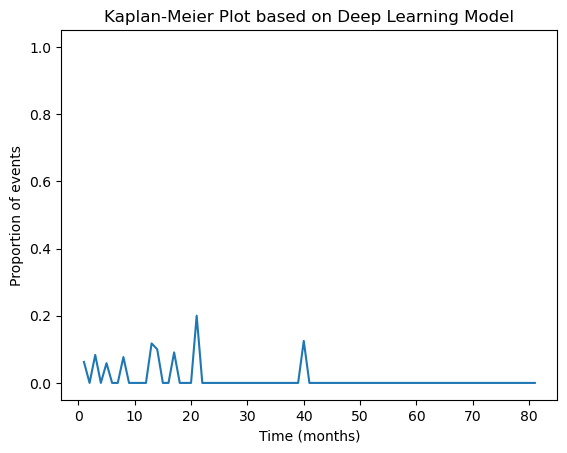

In [24]:
plt.plot(summarized["time"], summarized["mean"])
plt.ylim(-0.05, 1.05)
plt.title("Kaplan-Meier Plot based on Deep Learning Model")
plt.xlabel("Time (months)")
plt.ylabel("Proportion of events")
plt.show()

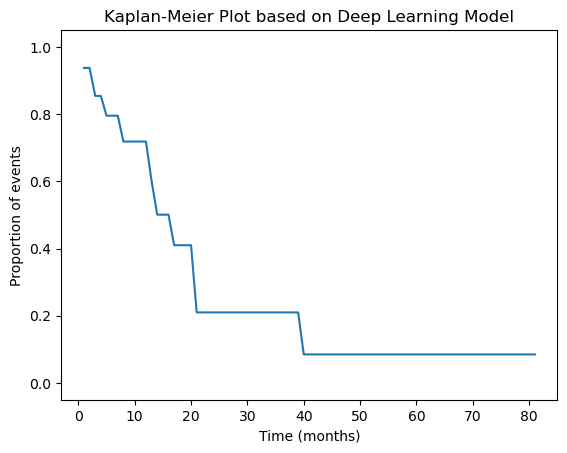

In [23]:
plt.plot(summarized["time"], 1-np.cumsum(summarized["mean"]))
plt.ylim(-0.05, 1.05)
plt.title("Kaplan-Meier Plot based on Deep Learning Model")
plt.xlabel("Time (months)")
plt.ylabel("Proportion of events")
plt.show()

In [4]:
Y_pred = pd.read_csv("preds.csv")

In [5]:
Y_pred["pred"] = [0 if pred_0 >= 0.5 else 1 for pred_0 in Y_pred["0"]]
Y_pred.head()

,Unnamed: 0,0,1,labels,pred
0,0,1.0,4.622921e-34,0,0
1,1,1.0,0.000000e+00,0,0
2,2,1.0,0.000000e+00,0,0
3,3,1.0,1.348687e-34,0,0
4,4,1.0,2.690777e-30,0,0


In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(Y_pred["labels"], Y_pred["pred"])
print(confusion_matrix)

[[432   3]
 [ 55   2]]


0.5851986287557975


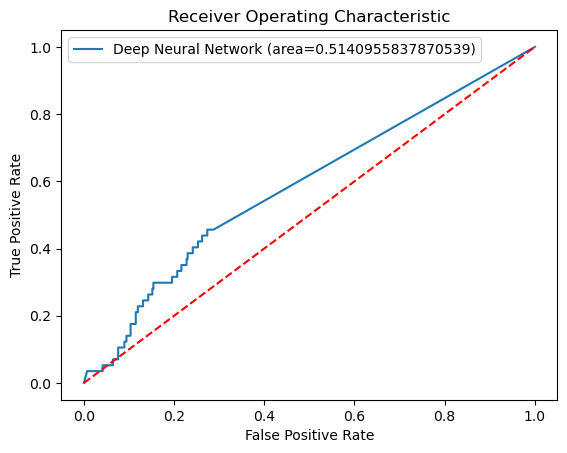

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

logit_roc_auc = roc_auc_score(Y_pred["labels"], Y_pred["pred"])
fp, tp, thresholds = roc_curve(Y_pred["labels"], Y_pred["1"])
print(auc(fp, tp))

plt.plot(fp, tp, label=f"Deep Neural Network (area={logit_roc_auc})")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()